In [1]:
# Import libraries
import pandas as pd
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.manifold import trustworthiness

In [2]:
# Set larger font sizes for better readability
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18
})

## Dimensionality Reduction analysis for unfiltered HCC SmartSeq dataset

In the following notebook, we will compare different dimensionality reduction techniques on the unfiltered HCC1806 SmartSeq dataset to evalaute to what extent the sparse and unprocessed data can be converted to a format suitable for clustering and, possibly also, for supervised classification.

In [3]:
# Load data
df = pd.read_csv("DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt",
                 delim_whitespace=True,
                 header=0,
                 quotechar='"',
                 index_col=0,
                 engine="python")

print("Original data shape (genes x samples):", df.shape)

# Transpose the data so that rows are samples and columns are genes/features
X = df.T.values
print("Transposed data shape (samples x features):", X.shape)

C:\Users\flamo\AppData\Local\Temp\ipykernel_23884\177241111.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt",


Original data shape (genes x samples): (3000, 14682)
Transposed data shape (samples x features): (14682, 3000)


In [4]:
# Extract condition information from column names
sample_names = df.columns
conditions = []
for name in sample_names:
    if "Norm" in name:
        conditions.append("Norm")
    elif "Hypo" in name:
        conditions.append("Hypo")
    else:
        conditions.append("Unknown")

# Create condition color mapping
colors = ["blue" if c == "Norm" else "red" if c == "Hypo" else "gray" for c in conditions]
condition_labels = np.array([0 if c == "Norm" else 1 if c == "Hypo" else 2 for c in conditions])

In [5]:
# Function to compute various evaluation metrics for dimensionality reduction
def evaluate_embeddings(original_data, embedding, labels):
    results = {}

    # 1. Silhouette score (higher is better)
    try:
        silhouette = silhouette_score(embedding, labels)
        results['silhouette_score'] = silhouette
    except:
        results['silhouette_score'] = np.nan
    
    results['trustworthiness'] = trustworthiness(original_data, embedding, n_neighbors = 5) 

    return results

In [6]:
# Standardize the data
standard_scaler = StandardScaler()
X_std = standard_scaler.fit_transform(X)

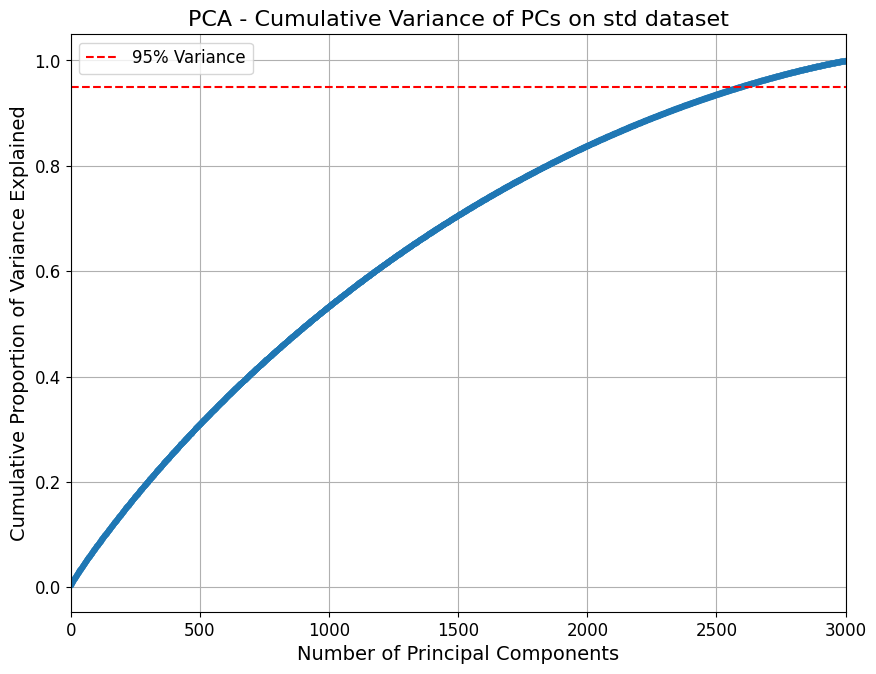

In [35]:
#after std, still 2600 PCs  out of 22000 possilbe explain more than 95% variance
pca_std = PCA(random_state=42)
pca_std.fit(X_std)
cumulative_variance = np.cumsum(pca_std.explained_variance_ratio_)

# Step 4: Plot
plt.figure(figsize=(10, 7.5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker=".", linestyle='-')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Variance')  # Red horizontal line
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.title('PCA - Cumulative Variance of PCs on std dataset')
plt.xlim(0,3000)
plt.grid(True)
plt.legend()
plt.show()

## Optimisation of parameters for UMAP and TSNE

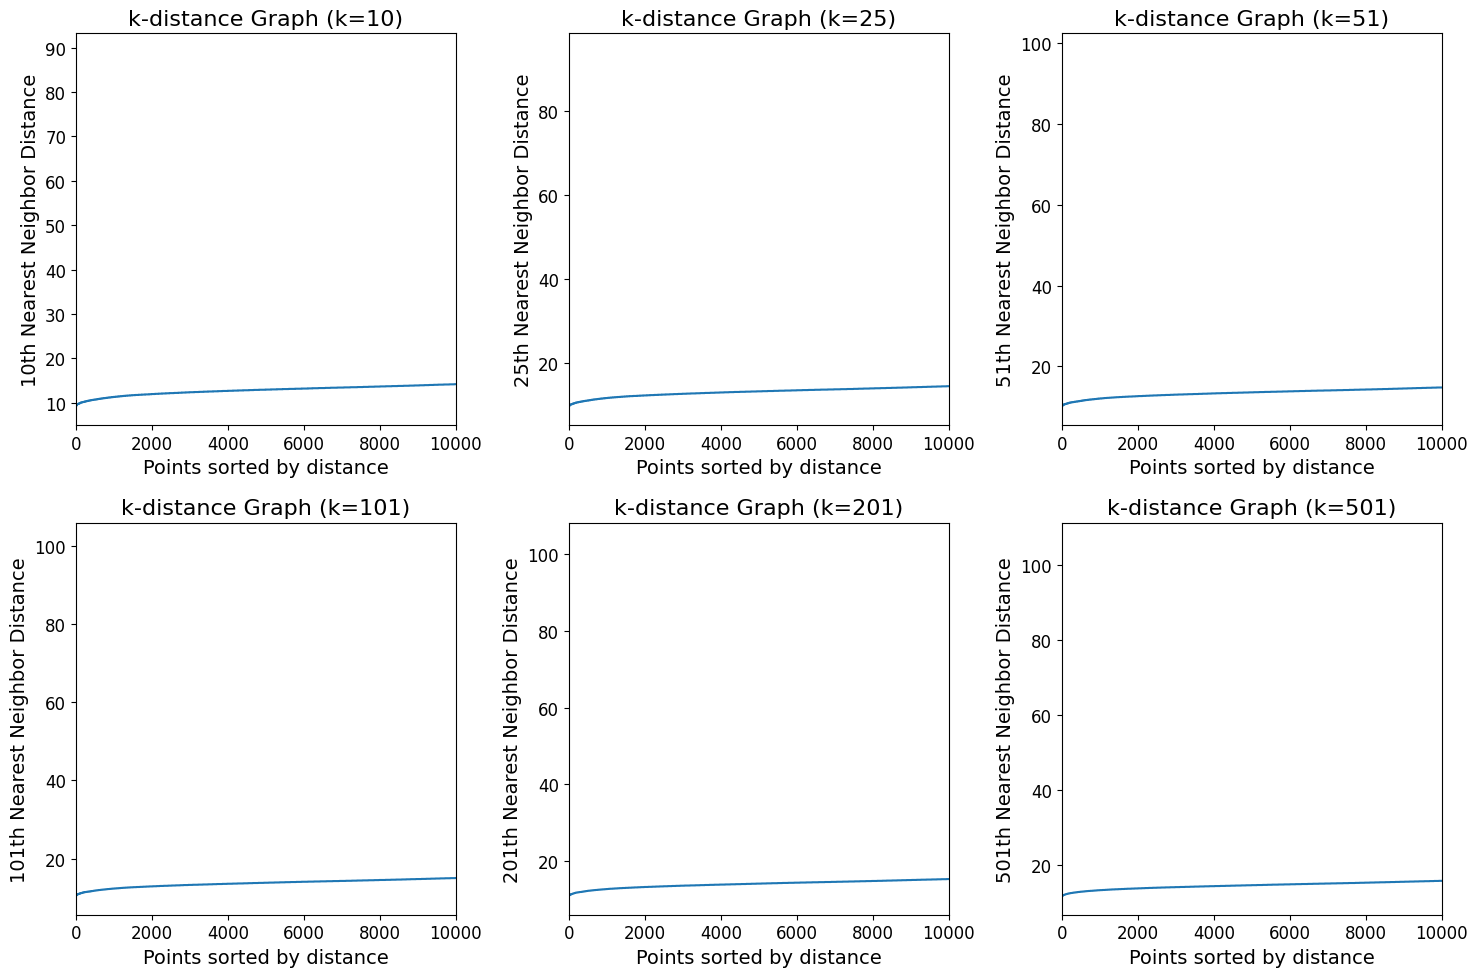

In [39]:
# k-distance analysis for UMAP parameter selection
k_values = [10, 25, 51, 101, 201, 501]

# Create subplots for each k-distance graph
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, k in enumerate(k_values):
    # Fit NearestNeighbors
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)

    # Get distances to k-th nearest neighbor
    distances, indices = neighbors_fit.kneighbors(X)
    sorted_distances = np.sort(distances[:, k - 1])  # k-1 for zero-indexed column

    # Plot the k-distance graph
    axs[i].plot(sorted_distances)
    axs[i].set_title(f'k-distance Graph (k={k})')
    axs[i].set_xlabel('Points sorted by distance')
    axs[i].set_ylabel(f'{k}th Nearest Neighbor Distance')
    axs[i].set_xlim(0,10000)

plt.tight_layout()
plt.savefig("hcc1806_k_distance_graphs.png", dpi=300)
plt.show()

In [9]:
# Define trustworthiness-based scoring function
def trustworthiness_scorer(estimator, X):
    X_embedded = estimator.named_steps['umap'].fit_transform(X)
    return trustworthiness(X, X_embedded, n_neighbors=25)

# Define pipeline: UMAP followed by nothing (or you can later add KMeans if needed)
pipe = Pipeline([
    ('umap', umap.UMAP(random_state=10))
])

# Parameter distribution using pipeline parameter names
param_dist = {
    'umap__n_neighbors': np.arange(5, 40),
    'umap__min_dist': np.linspace(0.0, 1, 50),
    'umap__metric': ['correlation', 'cosine'],
    
}

# Run RandomizedSearchCV using trustworthiness
search_U_T = RandomizedSearchCV( pipe,  param_distributions=param_dist, n_iter=25, cv=2, verbose=1, scoring=trustworthiness_scorer, random_state=22)

# Fit to data
search_U_T.fit(X)

# Print best parameters and best score
print("Best UMAP params:")
print(search_U_T.best_params_)
print(f"Best trustworthiness score: {search_U_T.best_score_:.4f}")

Fitting 2 folds for each of 25 candidates, totalling 50 fits


c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs valu

Best UMAP params:
{'umap__n_neighbors': 11, 'umap__min_dist': 0.2040816326530612, 'umap__metric': 'correlation'}
Best trustworthiness score: 0.7355


In [10]:
# Custom function to compute t-SNE and return trustworthiness
def evaluate_tsne_trustworthiness(X, n_components, perplexity, learning_rate, max_iter):
    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        learning_rate=learning_rate,
        max_iter=max_iter,
        random_state=10
    )
    X_embedded = tsne.fit_transform(X)
    trust = trustworthiness(X, X_embedded, n_neighbors=5)  # You can adjust n_neighbors
    return trust

# Define parameter ranges
n_components_range = [2, 3]
perplexity_range = np.arange(5, 51, 5)  # 5 to 50
learning_rate_range = np.logspace(-2, 2, 5)  # 0.01 to 100
max_iter_range = [250, 500, 1000]

# Number of random combinations to try
n_iter = 10

# Store results
results = []

# Random parameter search
for _ in range(n_iter):
    n_components = np.random.choice(n_components_range)
    perplexity = np.random.choice(perplexity_range)
    learning_rate = np.random.choice(learning_rate_range)
    max_iter_val = np.random.choice(max_iter_range)

    trust = evaluate_tsne_trustworthiness(
        X, n_components, perplexity, learning_rate, max_iter_val
    )
    results.append({
        'n_components': n_components,
        'perplexity': perplexity,
        'learning_rate': learning_rate,
        'max_iter': max_iter_val,
        'trustworthiness': trust
    })
    print(f"Iteration completed - Trustworthiness: {trust:.4f}")

# Find best parameters
best_result = max(results, key=lambda x: x['trustworthiness'])
print("\nBest parameters (by trustworthiness):")
print(f"t-SNE n_components: {best_result['n_components']}")
print(f"t-SNE perplexity: {best_result['perplexity']}")
print(f"t-SNE learning_rate: {best_result['learning_rate']}")
print(f"t-SNE max_iter: {best_result['max_iter']}")
print(f"Trustworthiness: {best_result['trustworthiness']:.4f}")

c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Impossibile trovare il file specificato
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  Fi

Iteration completed - Trustworthiness: 0.7422
Iteration completed - Trustworthiness: 0.8502
Iteration completed - Trustworthiness: 0.8712
Iteration completed - Trustworthiness: 0.8039
Iteration completed - Trustworthiness: 0.8143
Iteration completed - Trustworthiness: 0.7251
Iteration completed - Trustworthiness: 0.7257
Iteration completed - Trustworthiness: 0.7701
Iteration completed - Trustworthiness: 0.7777
Iteration completed - Trustworthiness: 0.7408

Best parameters (by trustworthiness):
t-SNE n_components: 3
t-SNE perplexity: 30
t-SNE learning_rate: 100.0
t-SNE max_iter: 1000
Trustworthiness: 0.8712


## Plotting results of dimensionality Reduction with best parameters

In [38]:
# Compute 2D and 3D embeddings using the best parameters
# For UMAP 2D
print("Computing UMAP 2D...")
umap_2d = umap.UMAP(
    n_neighbors=11,
    min_dist=0.204,
    n_components=2,
    metric = "correlation",
    random_state=23
)
umap_embedding_2d = umap_2d.fit_transform(X)

Computing UMAP 2D...


c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [31]:
# For UMAP 3D
print("Computing UMAP 3D...")
umap_3d = umap.UMAP(
    n_neighbors=11,
    min_dist=0.204,
    n_components=3,
    metric = "correlation",
    random_state=23
)
umap_embedding_3d = umap_3d.fit_transform(X)

Computing UMAP 3D...


c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [13]:
# For t-SNE 2D
print("Computing t-SNE 2D...")
tsne_2d = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=100,
    n_iter=1000,
    random_state=23
)
tsne_embedding_2d = tsne_2d.fit_transform(X)


Computing t-SNE 2D...


c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [32]:
# For t-SNE 3D
print("Computing t-SNE 3D...")
tsne_3d = TSNE(
    n_components=3,
    perplexity=30,
    learning_rate=100,
    n_iter=1000,
    random_state=23
)
tsne_embedding_3d = tsne_3d.fit_transform(X)

Computing t-SNE 3D...


c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [15]:
# For PCA
print("Computing PCA 2D...")
pca_2d = PCA(n_components=2, random_state=42)
pca_embedding_2d = pca_2d.fit_transform(X_std)

Computing PCA 2D...


In [16]:
print("Computing PCA 3D...")
pca_3d = PCA(n_components=3, random_state=42)
pca_embedding_3d = pca_3d.fit_transform(X_std)

Computing PCA 3D...


In [17]:
# Create legend elements for all plots
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=12, label='Norm'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=12, label='Hypo')
]

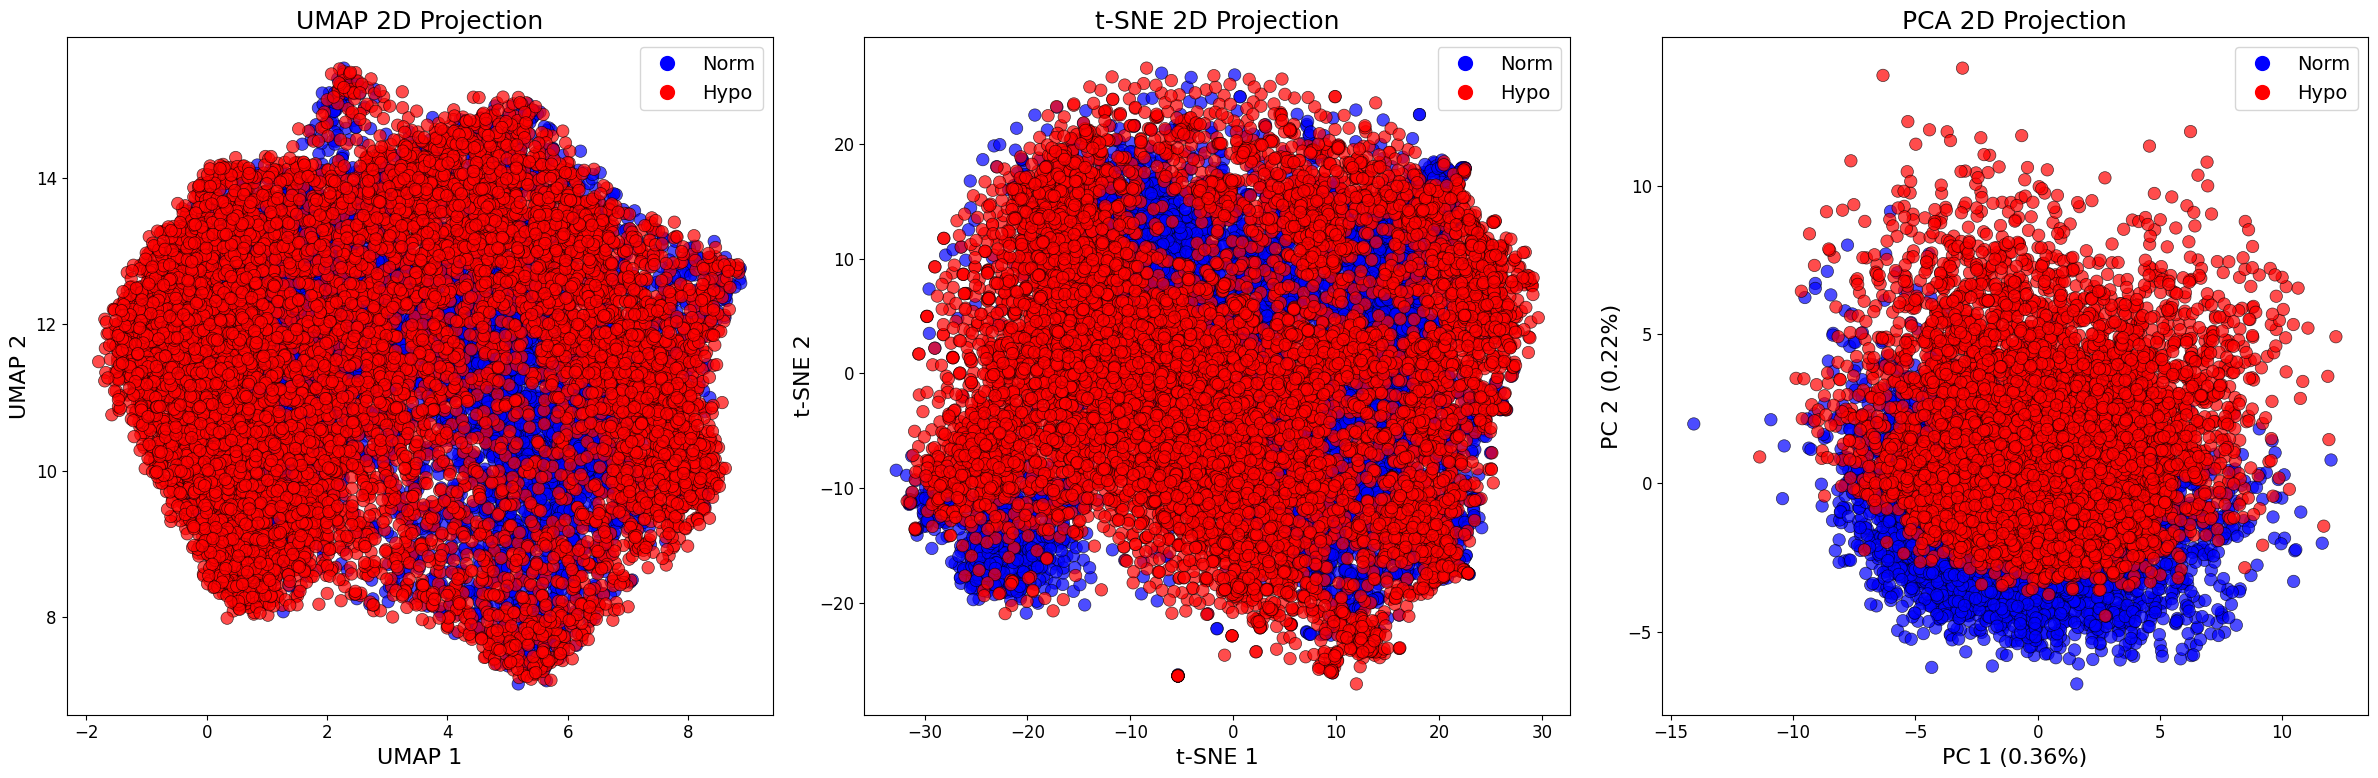

In [37]:
# Visualize 2D projections side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# UMAP 2D
axes[0].scatter(umap_embedding_2d[:, 0], umap_embedding_2d[:, 1], s=80, alpha=0.7, c=colors, edgecolor='k', linewidth=0.5)
axes[0].set_xlabel("UMAP 1", fontsize=16)
axes[0].set_ylabel("UMAP 2", fontsize=16)
axes[0].set_title("UMAP 2D Projection", fontsize=18)
axes[0].legend(handles=legend_elements, loc='best', fontsize=14)

# t-SNE 2D
axes[1].scatter(tsne_embedding_2d[:, 0], tsne_embedding_2d[:, 1], s=80, alpha=0.7, c=colors, edgecolor='k', linewidth=0.5)
axes[1].set_xlabel("t-SNE 1", fontsize=16)
axes[1].set_ylabel("t-SNE 2", fontsize=16)
axes[1].set_title("t-SNE 2D Projection", fontsize=18)
axes[1].legend(handles=legend_elements, loc='best', fontsize=14)

# PCA 2D
axes[2].scatter(pca_embedding_2d[:, 0], pca_embedding_2d[:, 1], s=80, alpha=0.7, c=colors, edgecolor='k', linewidth=0.5)
axes[2].set_xlabel(f"PC 1 ({pca_2d.explained_variance_ratio_[0]:.2%})", fontsize=16)
axes[2].set_ylabel(f"PC 2 ({pca_2d.explained_variance_ratio_[1]:.2%})", fontsize=16)
axes[2].set_title("PCA 2D Projection", fontsize=18)
axes[2].legend(handles=legend_elements, loc='best', fontsize=14)

plt.tight_layout()
plt.savefig("hcc1806_comparison_2d_projections.png", dpi=300)
plt.show()

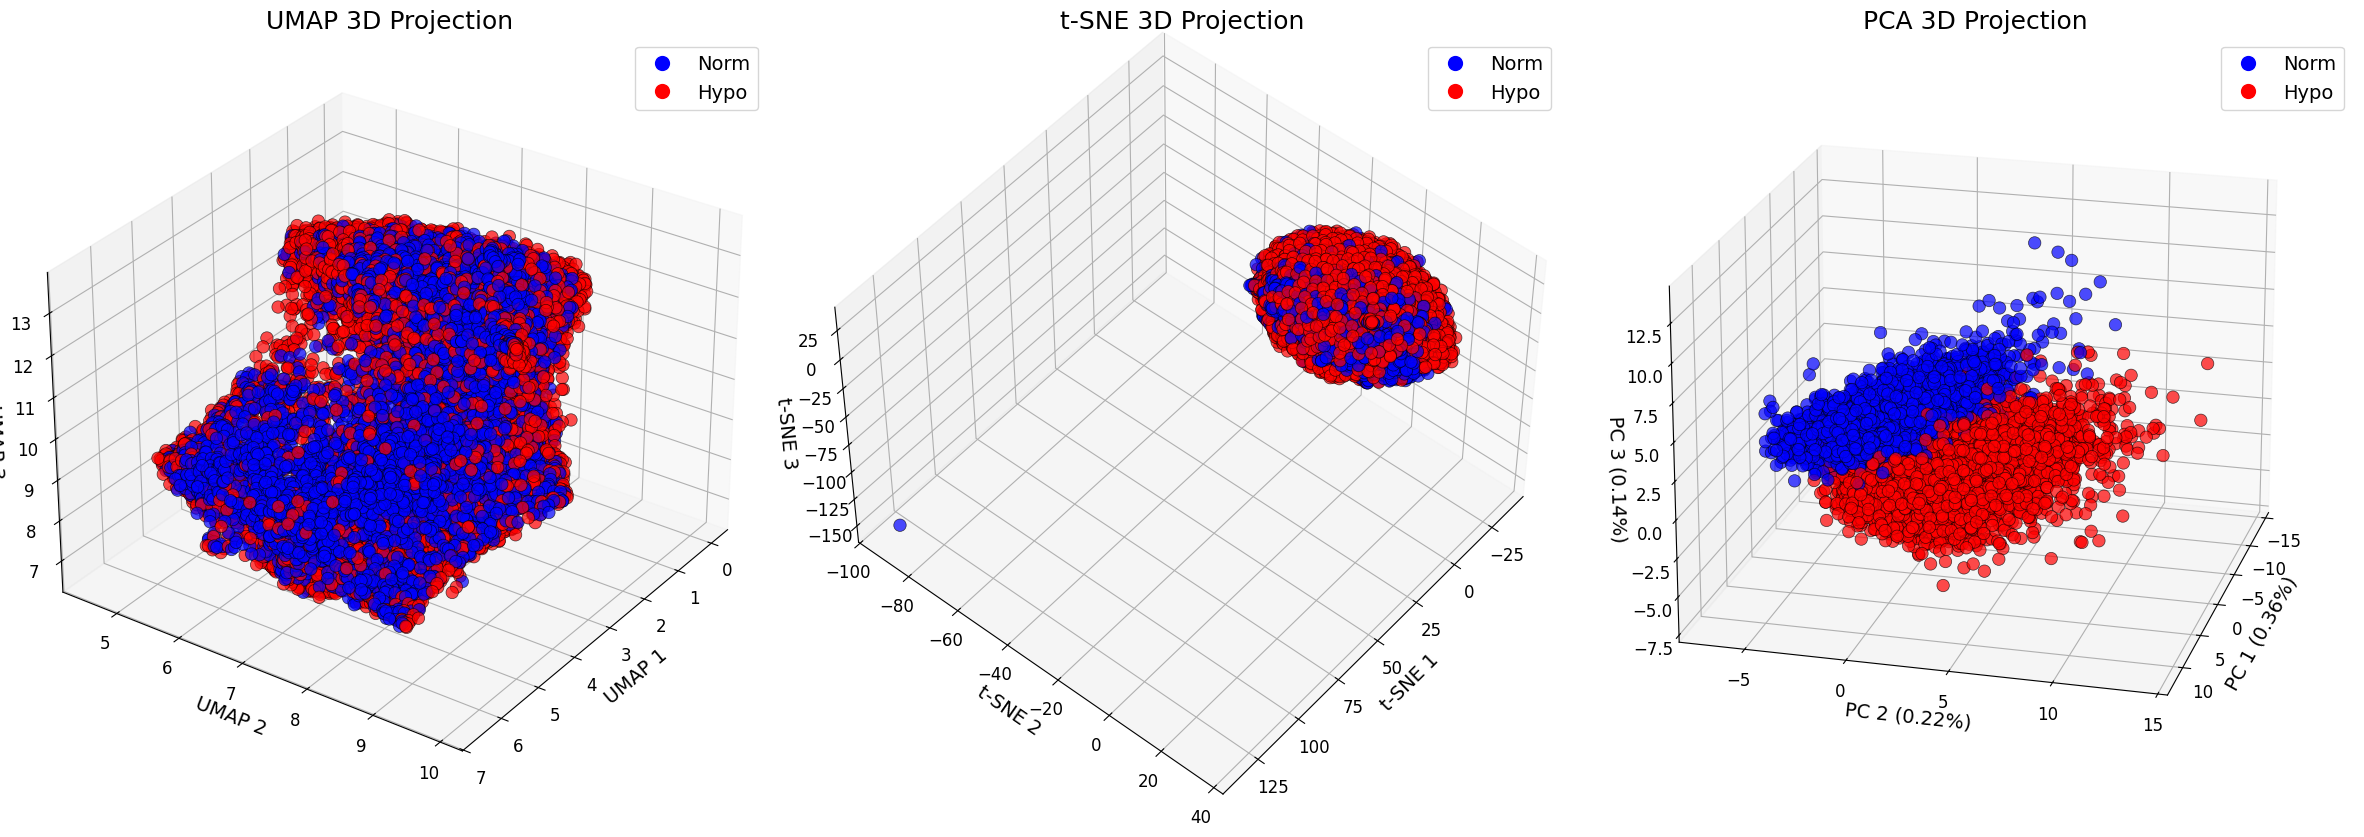

In [34]:
# Visualize 3D projections
fig = plt.figure(figsize=(24, 8))

# UMAP 3D
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(
    umap_embedding_3d[:, 0],
    umap_embedding_3d[:, 1],
    umap_embedding_3d[:, 2],
    c=colors, s=80, alpha=0.7, edgecolor='k', linewidth=0.5
)
ax1.set_xlabel("UMAP 1", fontsize=14)
ax1.set_ylabel("UMAP 2", fontsize=14)
ax1.set_zlabel("UMAP 3", fontsize=14)
ax1.set_title("UMAP 3D Projection", fontsize=18)
ax1.view_init(elev=30, azim=35)
ax1.legend(handles=legend_elements, loc='upper right', fontsize=14)

# t-SNE 3D
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(
    tsne_embedding_3d[:, 0],
    tsne_embedding_3d[:, 1],
    tsne_embedding_3d[:, 2],
    c=colors, s=80, alpha=0.7, edgecolor='k', linewidth=0.5
)
ax2.set_xlabel("t-SNE 1", fontsize=14)
ax2.set_ylabel("t-SNE 2", fontsize=14)
ax2.set_zlabel("t-SNE 3", fontsize=14)
ax2.set_title("t-SNE 3D Projection", fontsize=18)
ax2.view_init(elev=50, azim=40)
ax2.legend(handles=legend_elements, loc='upper right', fontsize=14)

# PCA 3D
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(
    pca_embedding_3d[:, 0],
    pca_embedding_3d[:, 1],
    pca_embedding_3d[:, 2],
    c=colors, s=80, alpha=0.7, edgecolor='k', linewidth=0.5
)
ax3.set_xlabel(f"PC 1 ({pca_3d.explained_variance_ratio_[0]:.2%})", fontsize=14)
ax3.set_ylabel(f"PC 2 ({pca_3d.explained_variance_ratio_[1]:.2%})", fontsize=14)
ax3.set_zlabel(f"PC 3 ({pca_3d.explained_variance_ratio_[2]:.2%})", fontsize=14)
ax3.set_title("PCA 3D Projection", fontsize=18)
ax3.view_init(elev=20, azim=15)
ax3.legend(handles=legend_elements, loc='upper right', fontsize=14)

plt.tight_layout()
plt.savefig("hcc1806_comparison_3d_projections.png", dpi=300)
plt.show()

## EVALUATION of PCA, UMAP and TSNE

In [20]:
# Evaluate each method
print("Evaluating methods...")
# Filter out any Unknown conditions
valid_indices = [i for i, c in enumerate(conditions) if c != "Unknown"]
valid_labels = condition_labels[valid_indices]
valid_X = X[valid_indices]
valid_X_std = X_std[valid_indices]

Evaluating methods...


In [21]:
# Evaluate 2D embeddings
umap_2d_metrics = evaluate_embeddings(valid_X, umap_embedding_2d[valid_indices], valid_labels)
tsne_2d_metrics = evaluate_embeddings(valid_X, tsne_embedding_2d[valid_indices], valid_labels)
pca_2d_metrics = evaluate_embeddings(valid_X_std, pca_embedding_2d[valid_indices], valid_labels)

In [22]:
# Evaluate 3D embeddings
umap_3d_metrics = evaluate_embeddings(valid_X, umap_embedding_3d[valid_indices], valid_labels)
tsne_3d_metrics = evaluate_embeddings(valid_X, tsne_embedding_3d[valid_indices], valid_labels)
pca_3d_metrics = evaluate_embeddings(valid_X_std, pca_embedding_3d[valid_indices], valid_labels)

In [23]:
# Combine results
all_metrics = {
    "UMAP 2D": umap_2d_metrics,
    "t-SNE 2D": tsne_2d_metrics,
    "PCA 2D": pca_2d_metrics,
    "UMAP 3D": umap_3d_metrics,
    "t-SNE 3D": tsne_3d_metrics,
    "PCA 3D": pca_3d_metrics
}

# Convert to DataFrame for easier comparison
metrics_df = pd.DataFrame(all_metrics).T
print("\nComparison of Dimensionality Reduction Methods:")
print(metrics_df)


Comparison of Dimensionality Reduction Methods:
          silhouette_score  trustworthiness
UMAP 2D           0.018093         0.734036
t-SNE 2D          0.020749         0.854615
PCA 2D            0.114097         0.505299
UMAP 3D           0.056960         0.771412
t-SNE 3D          0.033797         0.869002
PCA 3D            0.207457         0.508546


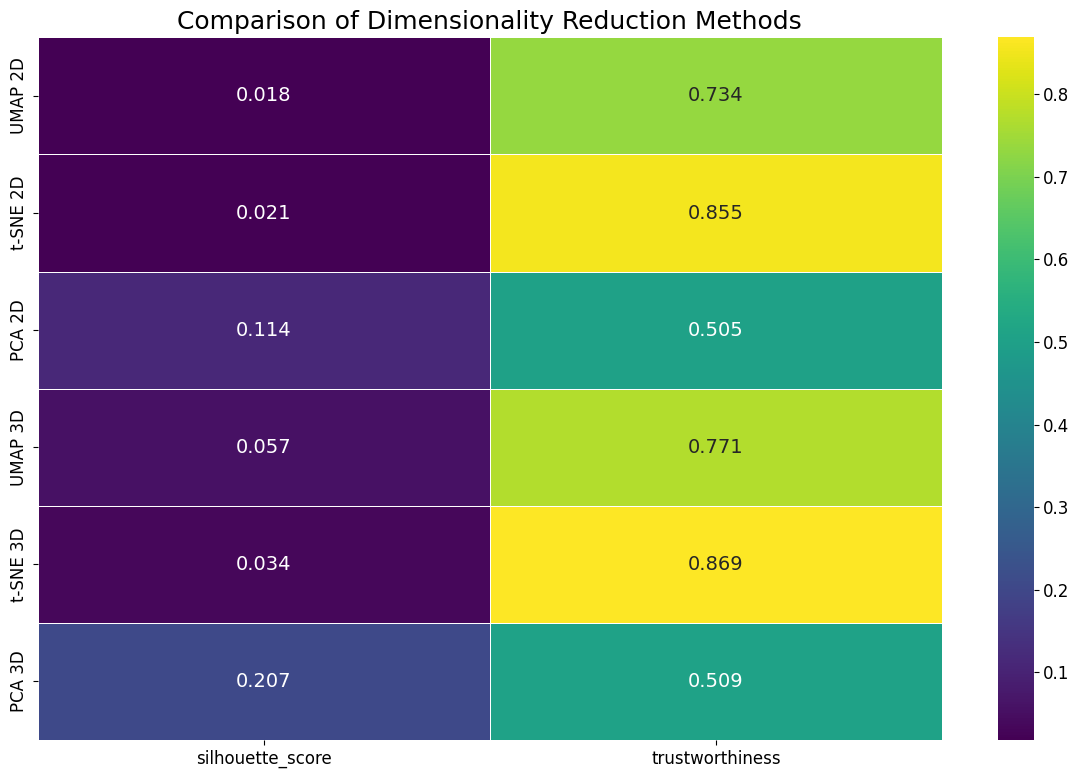

In [24]:
# Create a heatmap to visualize the comparison
plt.figure(figsize=(12, 8))
sns.heatmap(metrics_df, annot=True, cmap="viridis", linewidths=.5, fmt=".3f")
plt.title("Comparison of Dimensionality Reduction Methods", fontsize=18)
plt.tight_layout()
plt.savefig("hcc1806_method_comparison_heatmap.png", dpi=300)
plt.show()

In [25]:
# Calculate an overall score (weighted average of normalized metrics)
# Normalize metrics to 0-1
normalized_metrics = metrics_df.copy()

# For metrics where higher is better
for metric in ['silhouette_score']:
    min_val = normalized_metrics[metric].min()
    max_val = normalized_metrics[metric].max()
    if max_val > min_val:
        normalized_metrics[metric] = (normalized_metrics[metric] + 1) / 2

In [26]:
# Define weights for each metric
weights = {
    'silhouette_score': 0.5,  # Measures cluster separation
    'trustworthiness': 0.5,  # Measures preservation of local structure
}

# Calculate weighted score
normalized_metrics['weighted_score'] = sum(normalized_metrics[metric] * weight
                                         for metric, weight in weights.items())

# Sort by weighted score
normalized_metrics = normalized_metrics.sort_values('weighted_score', ascending=False)

print("\nRanking of Methods (higher is better):")
print(normalized_metrics[['weighted_score']])


Ranking of Methods (higher is better):
          weighted_score
t-SNE 3D        0.692950
t-SNE 2D        0.682495
UMAP 3D         0.649946
UMAP 2D         0.621541
PCA 3D          0.556137
PCA 2D          0.531173


<Figure size 1200x800 with 0 Axes>

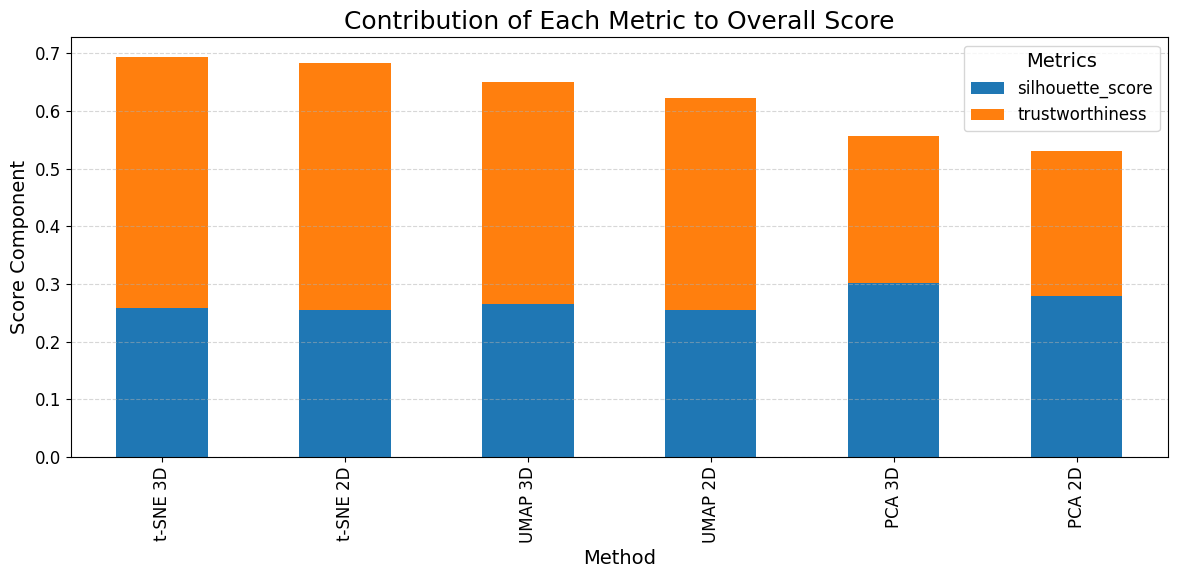

In [27]:
# Additional visualization: Contribution of each metric to overall score
contribution_df = pd.DataFrame({
    metric: normalized_metrics[metric] * weight
    for metric, weight in weights.items()
}, index=normalized_metrics.index)

plt.figure(figsize=(12, 8))
contribution_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Contribution of Each Metric to Overall Score', fontsize=18)
plt.xlabel('Method')
plt.ylabel('Score Component')
plt.legend(title='Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("hcc1806_score_components.png", dpi=300)
plt.show()